<img src="img/header.png"></img>

In [1]:
%load_ext autoreload
%autoreload 2 

import re
import datetime
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm, skew, boxcox, normaltest, boxcox_normmax
from scipy.special import boxcox1p


from sklearn import set_config
set_config(display='diagram')  

from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import mutual_info_regression

from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.impute import KNNImputer

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.pipeline import make_pipeline

from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.linear_model import LinearRegression

from category_encoders.cat_boost import CatBoostEncoder

# Flag to plot graphics or not
# Prints slow the notebook execution.
PLOT = True

In [2]:
## Download data from kaggle
#from util import get_data
#get_data()


### Functions

In [3]:
def plot_relationship(data, title):
    width = 8
    if len(data) > 70:
        width = 12
    fig, ax = plt.subplots(figsize=(width, 4))
    g = sns.barplot(x=data.index, y=data, ax=ax)
    ax.tick_params(axis="x", rotation=-90)
    ax.set_ylim(1.2 * data.min(), 1.2 * data.max())
    g.set_title(title)
    plt.tight_layout()


def plot_variance(pca):
    # Create figure
    fig, axs = plt.subplots(1, 2, figsize=(8,4))
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0))
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0))


def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


def get_missing(df, percent=False):
    if percent:
        missing = (df.isnull().sum() * 100 / df.isnull().count()).sort_values(
            ascending=False
        )
    else:
        missing = df.isnull().sum()

    missing = missing[missing > 0].sort_values(ascending=False)
    return missing


def get_rsquares(X, y):

    X = X.copy()

    model = LinearRegression()

    for col in X.select_dtypes("object"):
        X[col], _ = X[col].factorize()

    rsquares = {}
    for col in X.columns:
        X_, y_ = pd.get_dummies(X[col]), y
        model.fit(X_, y_)
        r2 = model.score(X_, y_)
        rsquares[col] = r2
    rsquares = pd.Series(rsquares)
    return rsquares


def make_mi_scores(X, y):
    X = X.copy()

    if isinstance(X, pd.DataFrame):
        for colname in X.select_dtypes("object"):
            X[colname], _ = X[colname].factorize()
        for colname in X.select_dtypes("category"):
            X[colname] = X[colname].cat.codes

    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(
        X, y, discrete_features=discrete_features, random_state=0
    )
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def custom_boxplot(X, y, **kwargs):
    sns.boxplot(x=X, y=y)
    x = plt.xticks(rotation=90)
    plt.tight_layout()


def get_low_cardinality(df, threshold):
    low_card = {
        col: len(df[col].unique()) for col in df if (len(df[col].unique())) <= threshold
    }
    return low_card


def get_high_cardinality(df, threshold):
    low_card = {
        col: len(df[col].unique()) for col in df if (len(df[col].unique())) > threshold
    }
    return low_card


def score_dataset(X, y, model=XGBRegressor()):
    X = X.copy()
    if isinstance(X, pd.DataFrame):
        for colname in X.select_dtypes(["category"]):
            X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    scores = np.sqrt(-cross_val_score(model, X, log_y, cv=5, scoring="neg_mean_squared_error"))
    return scores.mean()

def score_norm_dataset(X, y, model=XGBRegressor()):
    if isinstance(X, pd.DataFrame):
        for colname in X.select_dtypes(["category"]):
            X[colname] = X[colname].cat.codes
            
    rmsle = np.sqrt(-cross_val_score(model, X, y, cv=7, scoring="neg_mean_squared_error"))
    return np.mean(rmsle)

def rmsle(log_y, log_y_pred):
    return np.sqrt(mean_squared_error(log_y, log_y_pred))

def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]


def generate_submission_file(X_test, y_pred, score):
    # Concatenate the predictions in a dataset
    output = pd.DataFrame(y_pred, index=np.arange(1461,2920), columns=["SalePrice"])

    output["Id"] = output.index

    # Generate a file name with datetime info
    file_name = datetime.datetime.today().strftime(
        f"%Y_%m_%d__%H_%M_%S_with_score__{np.round(score,6)}"
    )
    # Generate the submission file
    output.to_csv(f"output/{file_name}__.csv", index=False)


def plot_interactions(data, X, hue, y="SalePrice"):
    sns.lmplot(
        data=data,
        x=X,
        y=y,
        hue=hue,
        col=hue,
        scatter_kws={"edgecolor": "w"},
        col_wrap=3,
        height=2,
    )


### 1. Exploratoy Data Analysis

##### 1.1 Data Preview

In [4]:
train = pd.read_csv("data/train.csv", index_col="Id")
X, y = train.drop("SalePrice", axis=1), train["SalePrice"]
X_test = pd.read_csv("data/test.csv", index_col="Id")


In [5]:
train.head(2)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [6]:
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [7]:
train = train.astype({"MSSubClass": object, "OverallQual": object, "OverallCond":object, "MoSold": object})
categorical_data = train.select_dtypes('object')
numerical_data = train.select_dtypes('number')


Categorical variables

In [8]:
categorical_data.head(2)


,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,RFn,TA,TA,Y,NaN,NaN,NaN,2,WD,Normal
2,20,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,RFn,TA,TA,Y,NaN,NaN,NaN,5,WD,Normal


Numerical discrete variables

In [9]:
numerical_data.head(2)


,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,2003,2003,196.0,706,0,150,856,856,...,548,0,61,0,0,0,0,0,2008,208500
2,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,...,460,298,0,0,0,0,0,0,2007,181500


##### 1.2 Missing Data <a id='missing_data'></a>

The dataset has some columns with considerable number os missing values:

&emsp;&emsp;__PoolQC, MiscFeature, Alley, Fence, FireplaceQu__ columns have more than 50 % of values missing.\
&emsp;&emsp;__Frontage__ has roughly 15 % of missing data.\
&emsp;&emsp;__Garage, Bsmt, and MasVnr__ have between 2% and 3% of missing data

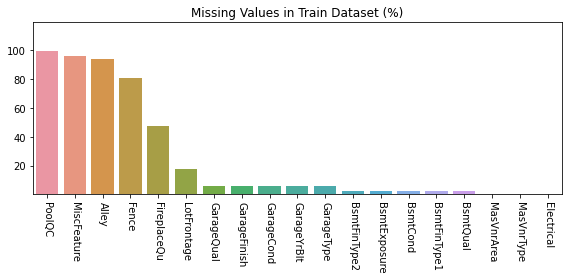

In [10]:
if PLOT:
    plot_relationship(get_missing(X, True), "Missing Values in Train Dataset (%)")

##### 1.3 Mutual Information

MI score can give us an idea of how much information about the target _SalePrice_ each feature has. The farther from zero it is, the more information it can provide about the target. In this dataset, the features **OverallQual**, **Neighborhood**, **GrLivArea**, **GarageArea**, **YearBuilt** and **ExternalQual** are good candidates for predictors to **SalePrice**. On the other hand, **MoSold** (Month Sold) and **PoolIQC** (Pool Quality) don**t seem to be good predictors.

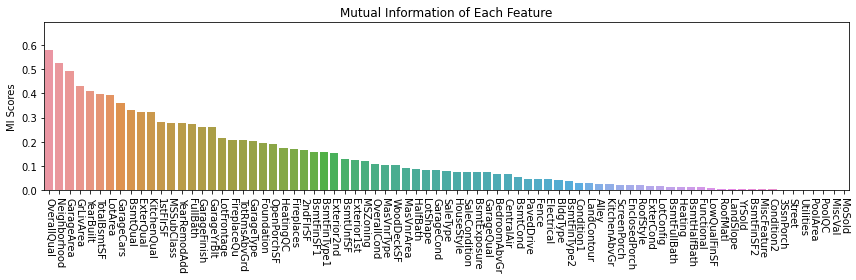

In [11]:
if PLOT:
    mi_scores = make_mi_scores(X.fillna(0), y)
    plot_relationship(mi_scores, "Mutual Information of Each Feature")


##### 1.4 Correlation

Correlation is a measures of **linear** association between two variables. Positive values indicate direct relationship, negative values indicate a inverse relationship.

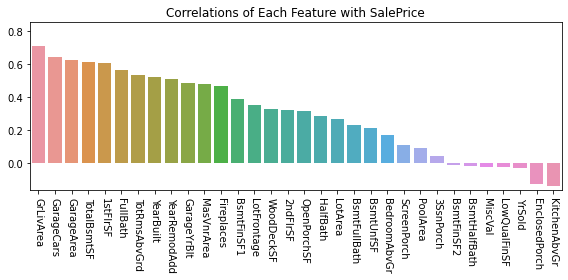

In [12]:
if PLOT:
    correlations = numerical_data.corrwith(numerical_data['SalePrice']).drop('SalePrice').sort_values(ascending=False)
    plot_relationship(correlations, "Correlations of Each Feature with SalePrice")


The **OverallQual**, **GrLivArea**, **GarageCars**, and **TotalBsmtSF** from moderate to strong correlation with **SalePrice**

Despite Correlation represents the linear association, different distribuitions of data can have the same correlation without the data even following the regression curve. So we need to take a look to the regression graphics and check if the correlations are good.

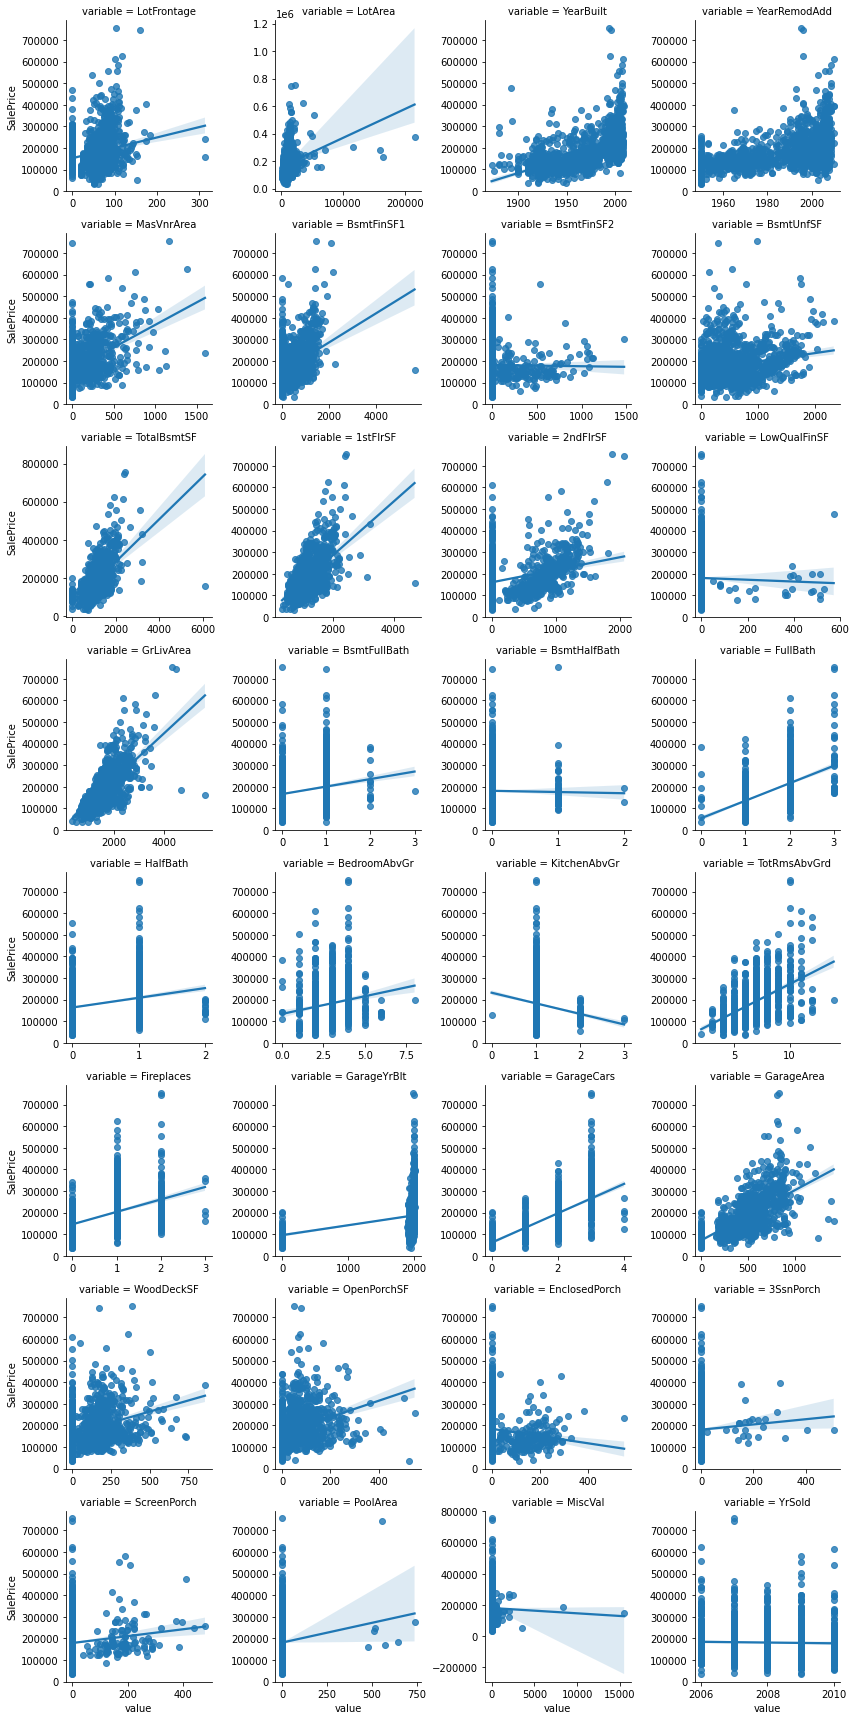

In [13]:
if PLOT:
    fg = pd.melt(
        numerical_data.fillna(0),
        id_vars=["SalePrice"],
    )
    g = sns.FacetGrid(
        fg, col="variable", col_wrap=4, sharex=False, sharey=False, height=3
    )
    g.map(sns.regplot, "value", "SalePrice")


As you can see **LotArea**, **MiscVal**, and **ScreenPorch** correlations are not reliable, although the correlation has values different from 0, the data distribution doesn't follow the regression line.

##### 1.5 R-square

Such as correlation, we can measure the degree of association between categorical variables and hour target. through the R-square, we can measure how much variation of **SalePrice** is explained by hour features.

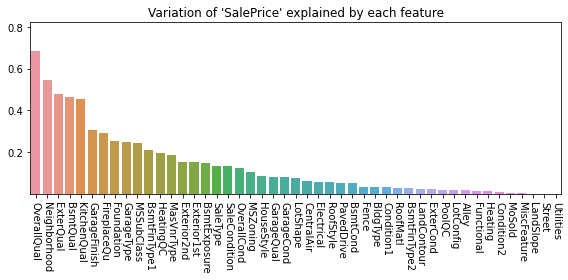

In [14]:
if PLOT:
    rsquares = get_rsquares(categorical_data, y).sort_values(ascending=False)
    plot_relationship(rsquares, "Variation of 'SalePrice' explained by each feature")


**OverallQual**, **Neighbornhood**, and **ExerQual** explain more than 50% from variation of **SalePrice**. Lets take a look to theese categorical variables.

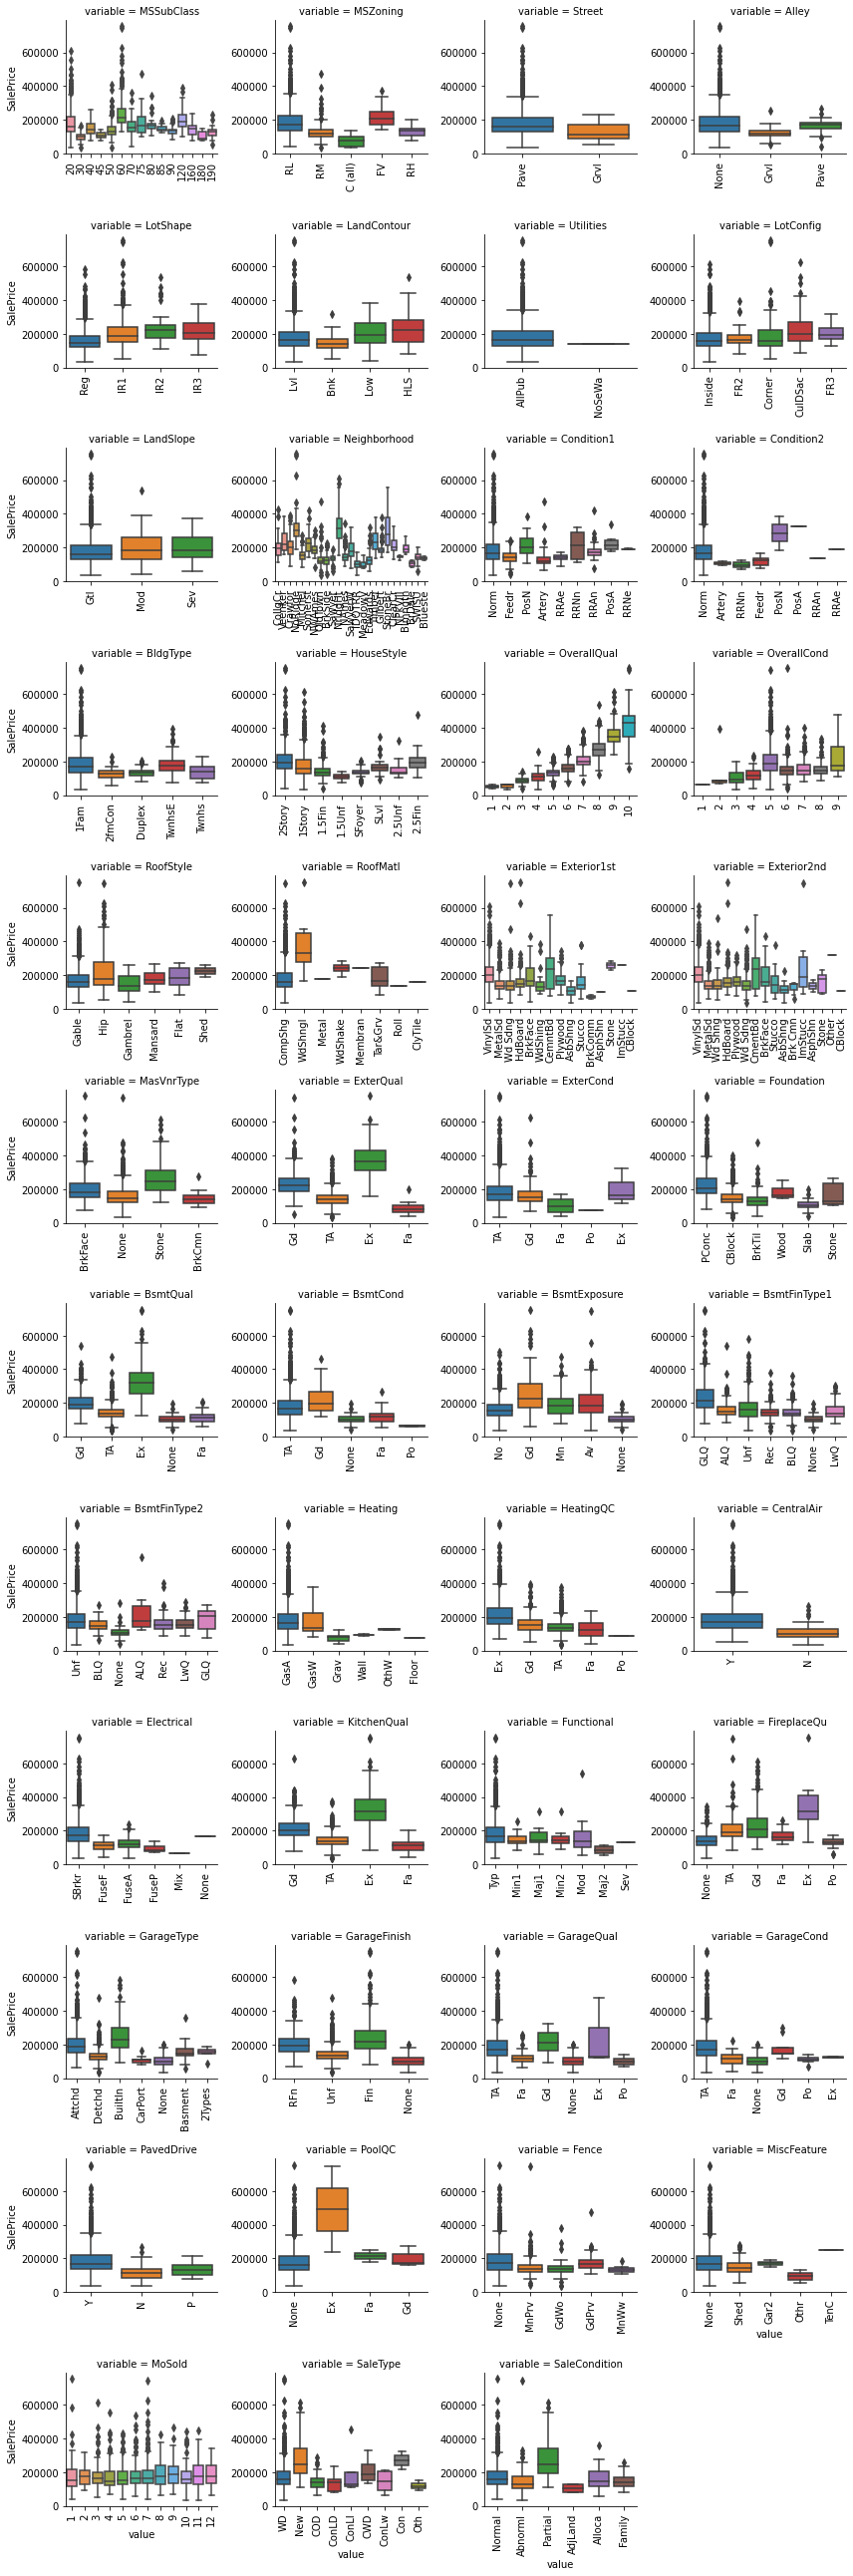

In [15]:
if PLOT:
    f = pd.melt(
        categorical_data.join(numerical_data['SalePrice']).fillna("None"),
        id_vars=["SalePrice"],
    )
    g = sns.FacetGrid(
        f, col="variable", col_wrap=4, sharex=False, sharey=False, height=3
    )
    g.map(custom_boxplot, "value", "SalePrice")


#### 1.6 Visualising Interactions

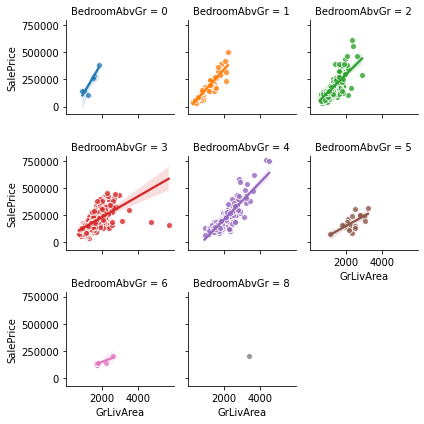

In [16]:
if PLOT:
    plot_interactions(train, 'GrLivArea', 'BedroomAbvGr')

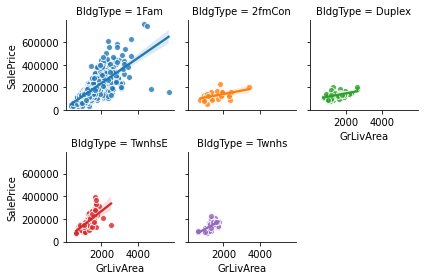

In [17]:
if PLOT:
    plot_interactions(train, 'GrLivArea', 'BldgType')

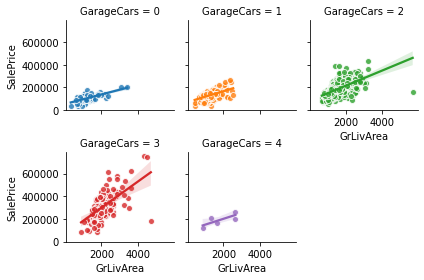

In [18]:
if PLOT:
    plot_interactions(train, 'GrLivArea', 'GarageCars')

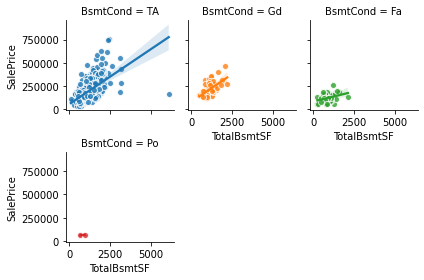

In [19]:
if PLOT:
    plot_interactions(train, 'TotalBsmtSF', 'BsmtCond')

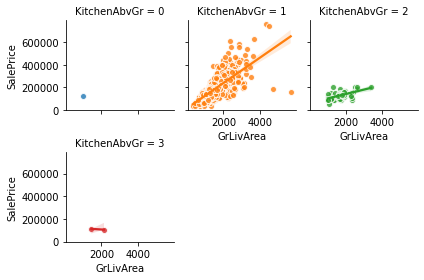

In [20]:
if PLOT:
    plot_interactions(numerical_data, 'GrLivArea', 'KitchenAbvGr')

### 2. Prepare Data


##### 2.1 Fix Typos

In [21]:
# Class FixTypos
class FixTypos:
    def __init__(self):
        return None

    def __repr__(self):
        return "FixTypos()"

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        self.X = X.copy()
        self.X.Exterior2nd = self.X.Exterior2nd.replace("Brk Cmn", "BrkComm")
        self.X.Exterior2nd = self.X.Exterior2nd.replace("CmentBd", "CemntBd")
        self.X.Exterior2nd = self.X.Exterior2nd.replace("Wd Shng", "Wd Sdng")
        self.X.BldgType = self.X.BldgType.replace("Twnhs", "TwnhsI")
        self.X.BldgType = self.X.BldgType.replace("2fmCon", "2FmCon")
        self.X.BldgType = self.X.BldgType.replace("Duplex", "Duplx")
        self.X.rename(
            columns={
                "1stFlrSF": "FirstFlrSF",
                "2ndFlrSF": "SecondFlrSF",
                "3SsnPorch": "Threeseasonporch",
            },
            inplace=True,
        )

        return self.X


To fix typos and some columns names i'll use the class FixTypos that perform the following replacements:

        'Brk Cmn' by 'BrkComm'
        'CmentBd' by 'CemntBd'
        'Wd Shng' by 'Wd Sdng'
        'Twnhs' by 'TwnhsI'
        '2fmCon' by '2FmCon'
        'Duplex' by 'Duplx'

and rename the columns;

        "1stFlrSF" to "FirstFlrSF"
        "2ndFlrSF" to "SecondFlrSF"
        "3SsnPorch" to "Threeseasonporch"

##### 2.2 Categorize Data

Ordinal categorical will be encoded as ordered **category** type. Unordered categorical data will be encoded as **category** but without any order.

In [22]:
# Categorical Data Dictionaries
# Unordered categorical columns
unordered_levels = {
    "MSSubClass": [20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 150, 160, 180, 190],
    "MSZoning": ["A", "C (all)", "FV", "I", "RH", "RL", "RP", "RM"],
    "Street": ["Grvl", "Pave"],
    "Alley": ["Grvl", "Pave", "None"],
    "LandContour": ["Lvl", "Bnk", "HLS", "Low"],
    "LotConfig": ["Inside", "Corner", "CulDSac", "FR2", "FR3"],
    "Neighborhood": [
        "Blmngtn",
        "Blueste",
        "BrDale",
        "BrkSide",
        "ClearCr",
        "CollgCr",
        "Crawfor",
        "Edwards",
        "Gilbert",
        "IDOTRR",
        "MeadowV",
        "Mitchel",
        "NAmes",
        "NoRidge",
        "NPkVill",
        "NridgHt",
        "NWAmes",
        "OldTown",
        "SWISU",
        "Sawyer",
        "SawyerW",
        "Somerst",
        "StoneBr",
        "Timber",
        "Veenker",
    ],
    "Condition1": [
        "Artery",
        "Feedr",
        "Norm",
        "RRNn",
        "RRAn",
        "PosN",
        "PosA",
        "RRNe",
        "RRAe",
    ],
    "Condition2": [
        "Artery",
        "Feedr",
        "Norm",
        "RRNn",
        "RRAn",
        "PosN",
        "PosA",
        "RRNe",
        "RRAe",
    ],
    "BldgType": ["1Fam", "2FmCon", "Duplx", "TwnhsE", "TwnhsI"],
    "HouseStyle": [
        "1Story",
        "1.5Fin",
        "1.5Unf",
        "2Story",
        "2.5Fin",
        "2.5Unf",
        "SFoyer",
        "SLvl",
    ],
    "RoofStyle": ["Flat", "Gable", "Gambrel", "Hip", "Mansard", "Shed"],
    "RoofMatl": [
        "ClyTile",
        "CompShg",
        "Membran",
        "Metal",
        "Roll",
        "Tar&Grv",
        "WdShake",
        "WdShngl",
    ],
    "Exterior1st": [
        "AsbShng",
        "AsphShn",
        "BrkComm",
        "BrkFace",
        "CBlock",
        "CemntBd",
        "HdBoard",
        "ImStucc",
        "MetalSd",
        "Other",
        "Plywood",
        "PreCast",
        "Stone",
        "Stucco",
        "VinylSd",
        "Wd Sdng",
        "WdShing",
    ],
    "Exterior2nd": [
        "AsbShng",
        "AsphShn",
        "BrkComm",
        "BrkFace",
        "CBlock",
        "CemntBd",
        "HdBoard",
        "ImStucc",
        "MetalSd",
        "Other",
        "Plywood",
        "PreCast",
        "Stone",
        "Stucco",
        "VinylSd",
        "Wd Sdng",
        "WdShing",
    ],
    "MasVnrType": ["BrkCmn", "BrkFace", "CBlock", "Stone", "None"],
    "Foundation": ["BrkTil", "CBlock", "PConc", "Slab", "Stone", "Wood"],
    "Heating": ["Floor", "GasA", "GasW", "Grav", "OthW", "Wall"],
    "CentralAir": ["N", "Y"],
    "GarageType": [
        "2Types",
        "Attchd",
        "Basment",
        "BuiltIn",
        "CarPort",
        "Detchd",
        "None",
    ],
    "MiscFeature": ["Elev", "Gar2", "Othr", "Shed", "TenC", "None"],
    "SaleType": [
        "WD",
        "CWD",
        "VWD",
        "New",
        "COD",
        "Con",
        "ConLw",
        "ConLI",
        "ConLD",
        "Oth",
    ],
    "SaleCondition": ["Normal", "Abnorml", "AdjLand", "Alloca", "Family", "Partial"],
}

# Ordered categorical columns
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
six_levels = ["None", "Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(1, 11))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": six_levels,
    "BsmtCond": six_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": six_levels,
    "GarageQual": six_levels,
    "GarageCond": six_levels,
    "PoolQC": ["None", "Fa", "TA", "Gd", "Ex"],
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["None", "No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["None", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["None", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["None", "Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["ELO", "NoSeWa", "NoSewr", "AllPub"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["None", "MnWw", "GdWo", "MnPrv", "GdPrv"],
}


ordered_cols = list(ordered_levels.keys())
unordered_cols = list(unordered_levels.keys())


To perform these categorization, the class CategorizeNominal was created.

In [23]:
# Class CategorizeNominal
class CategorizeNominal:
    def __init__(self, ordered_levels, unordered_levels):
        self.ordered_levels = ordered_levels
        self.unordered_levels = unordered_levels

    def __repr__(self):
        return "CategorizeNominal()"

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        self.X = X.copy()

        for col, levels in self.unordered_levels.items():
            self.X[col] = self.X[col].astype(CategoricalDtype(levels))
        for col, levels in self.ordered_levels.items():
            self.X[col] = self.X[col].astype(CategoricalDtype(levels, ordered=True))

        return self.X

Before feeding a model with data, all values must be numeric, so I'll use the class EncodeNominal to convert strings in columns to the numeric equivalent level

In [24]:
# Class EncodeCategories
class EncodeCategories:
    def __init__(self):
        return None

    def __repr__(self):
        return "EncodeCategories()"

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        self.X = X.copy()

        for colname in self.X.select_dtypes(["category"]):
            self.X[colname] = self.X[colname].cat.codes
        return self.X

##### 2.3 Missing Values

In [25]:
# Classes FillWith, FillByKNN, FillByGroup
class FillWith:

    """
    Fill a list of cols with a specified value

    >>> df = {'col1': [1, 2, NaN], 'col2': [4, 5, 6], 'col3': [7, NaN, 10]}
    >>> filler = FillWith(['col1', 'col2'], -1)
    >>> df_filled = filler.transform(df)

    >>> df_filled
       col1  col2 col3
    0     1     4    7
    1     2     5   -1
    2    -1     6   10

    """

    def __init__(self, cols=[], value="None"):
        self.cols = cols
        self.value = value

    def __repr__(self):
        return "FillWith(cols=%s, value=%s)" % (self.cols, self.value)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        self.X = X.copy()
        self.X[self.cols] = self.X[self.cols].fillna(self.value)
        return self.X


class FillByKNN:
    def __init__(self, n_neighbors=5, targets=None, keyword=None):
        self.n_neighbors = n_neighbors
        self.targets = targets
        self.keyword = keyword
        self.cols = None

    def fit(self, X, y=None):
        return self

    def __repr__(self):
        return "FillByKNN(n_neighbors=%i, targets=%s, keyword=%s,cols=%s)" % (
            self.n_neighbors,
            self.targets,
            self.keyword,
            self.cols,
        )

    def transform(self, X, y=None):

        self.X = X.copy()

        # If 'keyword' is none, use all the columns to estimate the KNN
        # else, use just columns that match the 'keyword'
        if self.keyword is None:
            self.cols_ = [col for col in self.X.columns]
        else:
            self.cols_ = [col for col in self.X.columns if self.keyword in col]

        # If 'targets' is none, use select all columns with missing value to fill
        if self.targets is None:
            self.targets_ = list(self.X.columns[self.X.isnull().any()])
            if self.keyword is not None:
                self.cols_ = list(set(self.targets + self.cols))
        else:
            self.targets_ = self.targets

        self.mapper = {}
        # Find each categorical column passed as arguments 'cols' and convert to numeric
        for col in self.cols_:
            if X[col].dtypes == "object" or X[col].dtypes == "category":
                # replace 'object' columns to 'numeric' versions and store nominal value in mapper
                # to reverse the transformation.
                self.X.loc[:, col], self.mapper[col] = self.X.loc[:, col].factorize()

        # Input missing values with KNNImputer
        self.imputer = KNNImputer(n_neighbors=self.n_neighbors)
        self.result = pd.DataFrame(
            self.imputer.fit_transform(self.X[self.cols_]),
            columns=self.cols_,
            index=self.X.index,
        )

        # Update targets with imputed data
        self.X.loc[:, self.targets_] = self.result[self.targets_]

        # Reverse to categorical values
        for col, unique in self.mapper.items():
            try:
                self.X.loc[:, col] = unique[self.X[col].astype(int)]
            except Exception as e:
                print(e)
                pass

        return self.X


class FillByGroup:

    """
    Group columns and fill based on a reference col.

    >>> df = {'HasCar': [NaN, 1, 1, NaN], 'CarMotor': [NaN, 2, 3, 4], 'CarWheelSize':[NaN, NaN, Large, NaN] 'Bike': [5, 6, 7, 8]}
    >>> filler = FillByGroup(group_ref = 'HasCar', group_keyword = 'Car', num_value= 0, cat_values = 'None')
    >>> df_filled = filler.transform(df)

    >>> df_filled
       HasCar  CarMotor CarWheelSize Bike
    0       0         0         None    5
    1       1         2          NaN    6
    2       1         3        Large    7
    3       0         4         None    8

    """

    def __init__(
        self, group_ref=None, group_keyword=None, num_value=0, cat_value="None"
    ):

        self.group_ref = group_ref
        self.group_keyword = group_keyword
        self.num_value = num_value
        self.cat_value = cat_value

    def __repr__(self):
        return (
            "FillByGroup(group_ref=%s, group_keyword=%s, num_value=%i, cat_value=%s)"
            % (self.group_ref, self.group_keyword, self.num_value, self.cat_value)
        )

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        self.X = X.copy()
        self.cols = [col for col in self.X.columns if self.group_keyword in col]
        self.null_mask = pd.isnull(self.X[self.group_ref])

        # split 'object' (str) and 'numeric' (int, float) columns
        self.num_cols = list(X[self.cols].select_dtypes("number").columns)
        self.object_cols = list(X[self.cols].select_dtypes("category").columns) + list(
            X[self.cols].select_dtypes("object").columns
        )

        self.X.loc[self.null_mask, self.num_cols] = self.X.loc[
            self.null_mask, self.num_cols
        ].fillna(self.num_value)

        self.X.loc[self.null_mask, self.object_cols] = self.X.loc[
            self.null_mask, self.object_cols
        ].fillna(self.cat_value)

        return self.X


As shown by [missing plot](#missing_data), the dataset has some missing values. Most data is missing because the feature doesn't exist, like a house that doesn't have **Pool**, **Alley**, **Fence**, **Basement**, or a **Garage**. 

To fill these data i'll use the class FillWith(). These columns will be filled with **None**

        FillWith(cols=['PoolQC', 'MiscFeature','Alley', 'Fence', 'FireplaceQu'], value='None')

The same occurs to Garage, MasVnr, and Bsmt data, but it these, each feature has a set of columns, so I'll use the class FillByGroup(). This class use as a parameter a column responsible for saying whether the house has the feature or not and a keyword used to find all columns corresponding to that feature (with similar names). These columns will be filled with '0' when numerical, and 'None' when categorical

        FillByGroup(group_ref='GarageType', group_keyword='Garage', cat_value='None')\
        FillByGroup(group_ref='BsmtCond', group_keyword='Bsmt', cat_value='None')\
        FillByGroup(group_ref='MasVnrType', group_keyword='MasVnr', cat_value='None')

Finally, the remaining missing columns will be filled using the class FillByKNN()

        FillByKNN(n_neighbors=1)

##### 2.4 Type Mismatch

In [26]:
#### Class ConvertToInt
class ConvertToInt:
    def __init__(self, cols):
        self.cols_ = cols

    def is_int(self, col):
        return np.array_equal(self.X[col], self.X[col].astype(int))

    def __repr__(self):
        return "ConvertToInt()"

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        self.X = X.copy()
        for col in self.cols_:
            if self.is_int(col):
                self.X[col] = self.X[col].astype(int)
        return self.X

Some columns have different dtypes between train and test data. This may be an issue when performing feature engineering, so I'll use the class ConvertToInt to fix this mismatch.

    ConvertToInt(cols=['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
                       'BsmtFullBath','BsmtHalfBath','GarageCars','GarageArea'])

In [27]:
X.loc[:, X_test.dtypes != X.dtypes].head(2)

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageCars,GarageArea
Id,,,,,,,,
1,706,0,150,856,1,0,2,548
2,978,0,284,1262,0,1,2,460


In [28]:
X_test.loc[:, X_test.dtypes != X.dtypes].head(2)

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageCars,GarageArea
Id,,,,,,,,
1461,468.0,144.0,270.0,882.0,0.0,0.0,1.0,730.0
1462,923.0,0.0,406.0,1329.0,0.0,0.0,1.0,312.0


### 3. Baseline

Now, I'll define a baseline to the model, this baseline will be made only using the data preparation steps above.

In [29]:
# Get a copy of data
X_train, y_train = X.copy(), y.copy()


#### 3.1 Base Pipeline

In [30]:
# base pipeline
fix_typos = FixTypos()

categorize_nominal = CategorizeNominal(ordered_levels, unordered_levels)
encode_nominal = EncodeCategories()

fill = make_pipeline(
    FillByGroup(group_ref="GarageType", group_keyword="Garage"),
    FillByGroup(group_ref="BsmtCond", group_keyword="Bsmt"),
    FillByGroup(group_ref="MasVnrType", group_keyword="MasVnr"),
    FillWith(
        cols=["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"], value="None"
    ),
    FillByKNN(n_neighbors=1),
)

convert_to_int = ConvertToInt(
    cols=[
        "BsmtFinSF1",
        "BsmtFinSF2",
        "BsmtUnfSF",
        "TotalBsmtSF",
        "BsmtFullBath",
        "BsmtHalfBath",
        "GarageCars",
        "GarageArea",
    ]
)

base_pipeline = make_pipeline(fix_typos, categorize_nominal, fill, encode_nominal, convert_to_int)


In [31]:
X_train_base = base_pipeline.fit_transform(X_train)
X_test_base = base_pipeline.transform(X_test)

#### 3.2 Score Baseline Dataset

In [32]:
# score_dataset function
def score_dataset(X, y, model=XGBRegressor()):
    X = X.copy()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    scores = np.sqrt(-cross_val_score(model, X, log_y, cv=5, scoring="neg_mean_squared_error"))
    return scores.mean()

In [33]:
baseline_model = XGBRegressor()
score_base = score_dataset(X_train_base, y_train, baseline_model)
score_base

0.13801466578140298

In [34]:
# generate_submission_file
def create_submission_file(name, y_pred, score):
    # Concatenate the predictions in a dataset
    output = pd.DataFrame(y_pred, index=np.arange(1461,2920), columns=["SalePrice"])

    output["Id"] = output.index

    # Generate a file name with datetime info
    file_name = datetime.datetime.today().strftime(
        f"%Y_%m_%d__%H_%M_%S_scored__{np.round(score,6)}"
    )
    # Generate the submission file
    output.to_csv(f"output/{name}_{file_name}__.csv", index=False)

In [35]:
baseline_model.fit(X_train_base, y_train)
y_pred_base = baseline_model.predict(X_test_base)
create_submission_file("baseline",y_pred_base, score_base)

### 4. Feature Engineering

#### 4.1 Mathematical, Countings, Grouping, and Interactions

Build some features can improve our model perfomance, let's test some new variables.


In [36]:
# Class BuildMathFeatures, BuildInteractionsFeatures, BuildGroupFeatures
class BuildMathFeatures:
    def __init__(self):
        return None

    def __repr__(self):
        return "BuildMathFeatures()"

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        self.X = X.copy()
        self.X["TotalFlrSF"] = self.X.FirstFlrSF + self.X.SecondFlrSF
        self.X["LivLotRatio"] = self.X.GrLivArea / self.X.LotArea
        self.X["LivRmRatio"] = self.X.GrLivArea / self.X.TotRmsAbvGrd
        self.X["Spaciouness"] = self.X.FirstFlrSF + self.X.SecondFlrSF / self.X.TotRmsAbvGrd

        return self.X


class BuildInteractionsFeatures:
    def __init__(self):
        self.enc1 = OneHotEncoder(sparse=False, handle_unknown="ignore")
        self.enc2 = OneHotEncoder(sparse=False, handle_unknown="ignore")
        self.enc3 = OneHotEncoder(sparse=False, handle_unknown="ignore")
        self.enc4 = OneHotEncoder(sparse=False, handle_unknown="ignore")
        self.enc5 = OneHotEncoder(sparse=False, handle_unknown="ignore")

        return None

    def __repr__(self):
        return "BuildInteractionsFeatures()"

    def fit(self, X, y=None):
        self.enc1.fit(X[["BedroomAbvGr"]])
        self.enc2.fit(X[["BldgType"]])
        self.enc3.fit(X[["GarageCars"]])
        self.enc4.fit(X[["BsmtCond"]])
        self.enc5.fit(X[["KitchenAbvGr"]])

        return self

    def transform(self, X, y=None):
        self.X = X.copy()

        X1 = self.enc1.transform(self.X[["BedroomAbvGr"]])
        X1 = pd.DataFrame(
            X1, columns=list(self.enc1.get_feature_names_out()), index=self.X.index
        )
        X1 = X1.mul(self.X.GrLivArea, axis=0)

        X2 = self.enc2.transform(self.X[["BldgType"]])
        X2 = pd.DataFrame(
            X2, columns=list(self.enc2.get_feature_names_out()), index=self.X.index
        )
        X2 = X2.mul(self.X.GrLivArea, axis=0)

            
        X3 = self.enc3.transform(self.X[["GarageCars"]])
        X3 = pd.DataFrame(
            X3, columns=list(self.enc3.get_feature_names_out()), index=self.X.index
        )
        X3 = X3.mul(self.X.GrLivArea, axis=0)


        X4 = self.enc4.transform(self.X[["BsmtCond"]])
        X4 = pd.DataFrame(
            X4, columns=list(self.enc4.get_feature_names_out()), index=self.X.index
        )
        X4 = X4.mul(self.X.TotalBsmtSF, axis=0)

        X5 = self.enc5.transform(self.X[["KitchenAbvGr"]])
        X5 = pd.DataFrame(
            X5, columns=list(self.enc5.get_feature_names_out()), index=self.X.index
        )
        X5 = X5.mul(self.X.GrLivArea, axis=0)

        self.X = pd.concat([self.X, X1], axis=1)
        return self.X


class BuildCountsFeatures:
    def __init__(self):
        return None

    def __repr__(self):
        return "BuildCountsFeatures()"

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        self.X = X.copy()
        self.X["Compartments"] = (
            self.X["TotRmsAbvGrd"] + self.X["KitchenAbvGr"] + self.X["FullBath"]
        )
        self.X["TotalFullBaths"] = self.X["BsmtFullBath"] + self.X["FullBath"]
        self.X["TotalHalfBaths"] = self.X["BsmtHalfBath"] + self.X["HalfBath"]
        return self.X


class BuildGroupFeatures:
    def __init__(self):
        return None

    def __repr__(self):
        return "BuildGroupFeatures()"

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        self.X = X.copy()
        self.X["Neigh_Area_mean"] = self.X.groupby("Neighborhood")["LotArea"].transform(
            "mean"
        )
        self.X["BedRm_LvArea_mean"] = self.X.groupby("BedroomAbvGr")["GrLivArea"].transform("mean")

        # new
        # self.X["Neigh_Area_mean"] = self.X.groupby("Neighborhood")["LotFrontage"].transform("mean")
        return self.X



Create features by **Matematical** operations between other columns in the dataset.

**Interactions** will expand the relationship between each category in a column and the target variables.

**Counts** features are columns generated by counting values from another column, or by counting features through other columns. 

Finnaly, **Group** features will group one features by another.

In [37]:
add_math_feat = BuildMathFeatures()
add_interactions_feat = BuildInteractionsFeatures()
add_count_feat = BuildCountsFeatures()
add_group_feat = BuildGroupFeatures()

#### 4.2 Standardizing

##### 4.2.1 Standardize Sale Price

In [38]:
# plot_distribuition, plot_dist_norm
def plot_distribuition(var):
    fig, ax = plt.subplots(1,2, figsize=(9, 3))

    skew_var = var.skew()
    kurt_var = var.kurt()
    g1 = sns.histplot(var, kde=True,color="#225480", ax=ax[0]);

    plt.legend(['Dist. (Skew = {:.2f}, Kurtoise = {:.2f} )'.format(skew_var, kurt_var)],
                loc='best')
                
    qqplot(var, line='s', ax=ax[1])

    plt.tight_layout()

    ax[0].set_ylabel("Frequency")
    ax[0].set_title("SalePrice distribution")
    ax[1].set_title('Quantile-Quantile')

def plot_dist_norm(var_n):
    fig, ax = plt.subplots(1,2, figsize=(9, 3))

    sns.histplot(var_n , kde=True, color="#207b7d", ax=ax[0]);
    (mu, sigma) = norm.fit(var_n)

    qqplot(var_n, line='s', ax=ax[1])

    ax[0].set_ylabel("Frequency")
    ax[0].set_title("SalePrice distribution")
    ax[1].set_title('Quantile-Quantile')

    ax[0].legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')

    plt.tight_layout()

Some algorithms benefit from normally distributed data, hence the non-normally distributed data will be transformed.

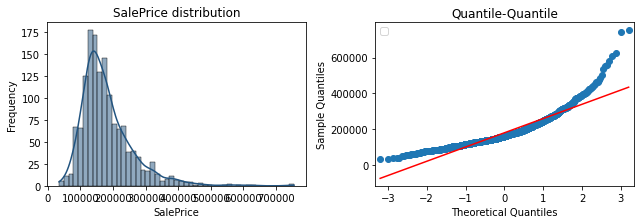

In [39]:
if PLOT:
    plot_distribuition(y_train)

In comparison with a normal curve, this data is right-skewed, and the positive kurtosis indicates a more tapered and concentrated curve, which too indicated fewer outliers.

From the q-q plot we can infer that the data are not normal, as if they were the points would fall approximately on the red line.Being more rigorous and using a statistical test:

In [40]:
k2, p = normaltest(y_train)
alpha = 1e-3
print("p = {:g}".format(p))
print("'null hypothesis': data distribuition is normal")
if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The 'null hypothesis' can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 2.28385e-133
'null hypothesis': data distribuition is normal
The 'null hypothesis' can be rejected


normalize the target

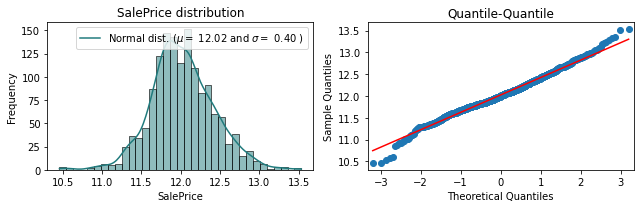

In [41]:
y_train_n = np.log1p(y_train)
if PLOT:
    plot_dist_norm(y_train_n)

##### 4.2.2 Standardize Features

In [42]:
# class StandardizeFeatures
class StandardizeFeatures:
    def __init__(self, skewed_cols):
        self.cols = skewed_cols

    def fit(self, X, y):
        return self

    def transform(self, X, y=None):
        self.X = X.copy()
        self.X[self.cols]
        try:
            self.X[self.cols] = self.X[self.cols].apply(
                lambda x: boxcox1p(x, boxcox_normmax(x + 1)), axis=0
            )
            return self.X
        except Exception as e:
            print(e)

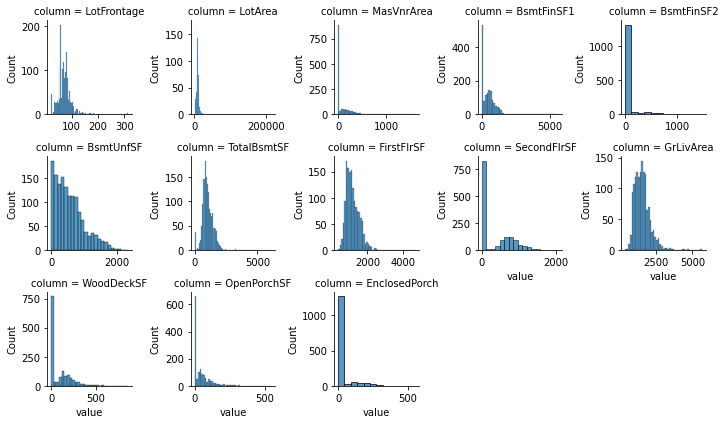

In [43]:
df_numbers = X_train_base.drop(unordered_cols + ordered_cols, axis=1)
filter_skewed = (df_numbers.skew() > 0.5) & (df_numbers.nunique() > 100)
skewd_feat = filter_skewed[filter_skewed].index

if PLOT:
    melted_df = pd.melt(
        X_train_base[skewd_feat],
        var_name='column'
    )
    g = sns.FacetGrid(melted_df, col='column', col_wrap=5, sharex=False, sharey=False, height=2)
    g.map(sns.histplot, 'value')

In [44]:
skewed_cols = [
    "LotFrontage",
    "LotArea",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
]

standardize_feat = StandardizeFeatures(skewed_cols=skewed_cols)


###  5. K-means clustering

In [45]:
# Class BuildCluster
class BuildCluster:
    def __init__(self, cols, n_clusters, n_init=50, name="Cluster"):
        self.cols = cols
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.name = name

    def __repr__(self):
        return "BuildGroupFeatures(cols=%s, n_clusters=%s, n_init=%i, name=%s)" % (
            self.cols,
            self.n_clusters,
            self.n_init,
            self.name,
        )

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        self.X = X.copy()

        # select a set of columns to perform clustering
        self.X_cols = self.X[self.cols].copy()

        # convert any categorical variable to numerical
        for colname in self.X_cols.select_dtypes(["category"]):
            self.X_cols[colname] = self.X_cols[colname].cat.codes

        self.X_cols = self.X_cols.astype(int)

        # scale the data set
        self.X_scaled = (self.X_cols - self.X_cols.mean(axis=0)) / self.X_cols.std(
            axis=0
        )  
        
        # perform the fitting
        self.kmeans = KMeans(
            n_clusters=self.n_clusters, n_init=self.n_init, random_state=0
        )

        self.X[self.name] = self.kmeans.fit_predict(self.X_scaled)
        self.X[self.name] = self.X[self.name].astype("category")

        return self.X

We can group data points by similarity using clustering and use the clusters to see how much our model improves.
I'll use data from house characteristics like, roof style, roof material, mansory veneer type, foundation etc.

#### 5.1 Search the best number of clusters

In [46]:
# Search Best K
def search_best_k(df, targets, cols, trials):
    best_score = 100
    for k in range(1, trials):
        add_cluster = BuildCluster(cols, k, 50, name="Cluster1")
        df_with_cluster = add_cluster.transform(df)
        
        score = score_dataset(df_with_cluster, targets)
        if score < best_score:
            best_score = score
            print(">", end="")
        print(f"{k}, {score}")

In [47]:
""" variables = ["RoofStyle", "RoofMatl"]
search_best_k(X_train_base, y_train, variables, 21) """


' variables = ["RoofStyle", "RoofMatl"]\nsearch_best_k(X_train_base, y_train, variables, 21) '

Here are some scores found and variables that was used
|n_clusters| variables |
| --- |  --- |
| 4   | ["RoofStyle", "RoofMatl","MasVnrType"]|
|11   | ["RoofStyle", "RoofMatl","Exterior1st" , "MasVnrType", "ExterCond", "ExterQual", "Foundation"] |
|15   | ["RoofStyle", "RoofMatl"] |

#### 5.2 Create pipeline to add cluster

Using the class BuildCluster that add a cluster column to the data

In [48]:
variables = [
    "RoofStyle",
    "RoofMatl",
    "Exterior2nd",
    "MasVnrType",
    "ExterCond",
    "ExterQual",
    "Foundation",
]
add_cluster = BuildCluster(variables, 8, 50, name="Cluster1")

### 6. Principal Component Analysis

In [49]:
# Class BuildPCA
class BuildPCA:
    def __init__(self, cols, drop_originals=False, use_n_components=None):
        self._cols = cols
        self._pca = None
        self._X_pca = None
        self._loadings = None
        self._drop_originals = drop_originals
        self._use_n_components = use_n_components

    def __repr__(self):
        return "BuildPCA(cols=%s)" % (self._cols)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        
        self.X = X.copy()

        self._pca, self._X_pca, self._loadings = self._apply_pca(self.X, self._cols)

        if self._use_n_components:
            self._X_pca = self._X_pca.iloc[:, : self._use_n_components]

        self.X = pd.concat([self.X, self._X_pca], axis=1)

        if self._drop_originals:
            self.X = self.X.drop(self._cols, axis=1)
        return self.X

    def _apply_pca(self, X, features):

        X = X.loc[:, features]

        for colname in X.select_dtypes(["category"]):
            X[colname] = X[colname].cat.codes

        X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

        pca = PCA()
        X_pca = pca.fit_transform(X_scaled)

        component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]

        X_pca = pd.DataFrame(X_pca, columns=component_names, index=X_scaled.index)

        loadings = pd.DataFrame(
            pca.components_.T,  # transpose the matrix of loadings
            columns=component_names,  # so the columns are the principal components
            index=X.columns,  # and the rows are the original features
        )

        return pca, X_pca, loadings

    def get_variables(self):
        return self._cols

    def get_x_pca(self):
        return self._X_pca

    def get_pca(self):
        return self._pca

    def get_loadings(self):
        return self._loadings

PCA is a dimensionality-reduction method that helps to reduce the number of variables of a data set by transform _p_ variables into _k_ principal components, then often a _k_ < _p_ will store the most of the variation of _p_ variables.

When we have a large number of correlated variables in a data set, we can reduce to just a few principal componets with still explain the most of the variance of the original variables.

Also, because we just keep the principal components, the main of the information is kept, and the noise is removed.

A less number of variables transform makes our model more computationally efficient.

#### 6.1 Selecting High correlated variables

In [50]:
## Thank you @mikkom from stackoverflow to that piece of code
corr = X_train_base.select_dtypes('number').corr().stack()

# Ignore autocorrelation
corr = corr[corr.index.get_level_values(0) != corr.index.get_level_values(1)]

# Select only highly correlated (ρ => 0.8)
high_corr = corr[corr > 0.8]
high_corr


Exterior1st   Exterior2nd     0.870791
Exterior2nd   Exterior1st     0.870791
TotalBsmtSF   FirstFlrSF      0.819530
FirstFlrSF    TotalBsmtSF     0.819530
GrLivArea     TotRmsAbvGrd    0.825489
TotRmsAbvGrd  GrLivArea       0.825489
Fireplaces    FireplaceQu     0.863241
FireplaceQu   Fireplaces      0.863241
GarageYrBlt   GarageQual      0.946629
              GarageCond      0.949411
GarageCars    GarageArea      0.882475
GarageArea    GarageCars      0.882475
GarageQual    GarageYrBlt     0.946629
              GarageCond      0.959172
GarageCond    GarageYrBlt     0.949411
              GarageQual      0.959172
PoolArea      PoolQC          0.899924
PoolQC        PoolArea        0.899924
dtype: float64

In [51]:
# Parse to a list
high_corr_variables = high_corr.index.unique(level=0)
high_corr_variables

Index(['Exterior1st', 'Exterior2nd', 'TotalBsmtSF', 'FirstFlrSF', 'GrLivArea',
       'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolArea',
       'PoolQC'],
      dtype='object')

#### 6.2 Create Pipeline to add PCA

With PCA we can either, substitute the original variables by computed PCA's and discard less informative variables, use loadings to inspire combination of variables. I choose the first option.

Passing a argument _drop_originals=True_, the transformed variables will be used instead of the original, and the _use_n_components=n_ will define the number of PCA used ( PC1, PC2,...,PCn)

In [52]:
add_pca = BuildPCA(high_corr_variables, drop_originals=True, use_n_components=4)


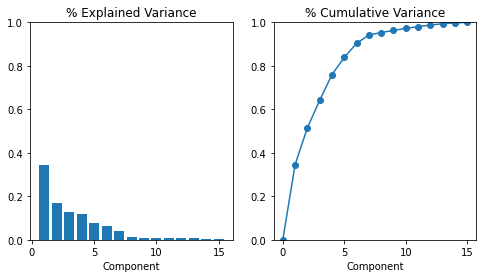

In [53]:
pipe_pca = make_pipeline(base_pipeline, add_pca)
X_train_pca = pipe_pca.fit_transform(X_train)

pca = pipe_pca[1].get_pca()

if PLOT:
    plot_variance(pca)

### 7. Targeting Encoding

In [54]:
# Class CrossFoldEncoder
class CrossFoldEncoder:
    def __init__(self, encoder, cols, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)
        self.cols = cols

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit(self, X, y=None):
        return self

    def fit_transform(self, X, y):
        self.fitted_encoders_ = []
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=self.cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :],
                y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[self.cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X.join(X_encoded)

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols])
        X_encoded = reduce(lambda x, y: x.add(y, fill_value=0), X_encoded_list) / len(
            X_encoded_list
        )
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X.join(X_encoded)

In [55]:
low_cadinality = (X_train_base.nunique() > 10) & (X_train_base.nunique() < 250) 
target_enc_cols = low_cadinality[low_cadinality].index
target_enc_cols

Index(['MSSubClass', 'LotFrontage', 'Neighborhood', 'YearBuilt',
       'YearRemodAdd', 'Exterior1st', 'Exterior2nd', 'BsmtFinSF2',
       'LowQualFinSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'OpenPorchSF',
       'EnclosedPorch', 'Threeseasonporch', 'ScreenPorch', 'MiscVal',
       'MoSold'],
      dtype='object')

In [56]:
target_encoder = CrossFoldEncoder(CatBoostEncoder , cols=["ScreenPorch", "Neighborhood"])

In [57]:
ohe_cols = [
    "MSSubClass",
    "MSZoning",
    "Street",
    "Alley",
    "LotShape",
    "LandContour",
    "Utilities",
    "LotConfig",
    "LandSlope",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "OverallCond",
    "RoofStyle",
    "RoofMatl",
    "MasVnrType",
    "ExterQual",
    "ExterCond",
    "Foundation",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "Heating",
    "CentralAir",
    "Electrical",
    "KitchenQual",
    "Functional",
    "GarageType",
    "GarageFinish",
    "PavedDrive",
    "Fence",
    "MiscFeature",
    "MoSold",
    "SaleType",
    "SaleCondition",
]

ohe = make_column_transformer(
    (
        OneHotEncoder(sparse=False, handle_unknown="ignore"),
        ohe_cols,
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

final_pipeline = make_pipeline(
    base_pipeline,
    add_math_feat,
    convert_to_int,
    add_interactions_feat,
    add_count_feat,
    #add_group_feat,
    #add_cluster,
    #add_pca,
    # target_encoder,
    ohe,
)

X_train_final = final_pipeline.fit_transform(X_train, y_train)
X_test_final = final_pipeline.transform(X_test)


In [58]:
X_train_final_df = pd.DataFrame(X_train_final, columns=final_pipeline[-1].get_feature_names_out())
X_test_final_df = pd.DataFrame(X_test_final, columns=final_pipeline[-1].get_feature_names_out())

In [59]:
X_test_final_df.columns

Index(['MSSubClass_0', 'MSSubClass_1', 'MSSubClass_2', 'MSSubClass_3',
       'MSSubClass_4', 'MSSubClass_5', 'MSSubClass_6', 'MSSubClass_7',
       'MSSubClass_8', 'MSSubClass_9',
       ...
       'BedroomAbvGr_1', 'BedroomAbvGr_2', 'BedroomAbvGr_3', 'BedroomAbvGr_4',
       'BedroomAbvGr_5', 'BedroomAbvGr_6', 'BedroomAbvGr_8', 'Compartments',
       'TotalFullBaths', 'TotalHalfBaths'],
      dtype='object', length=299)

### 8. Feature Selection

#### 8.2 Filter using RFE

In [60]:
import pickle
from os.path import exists, isdir


if not exists("models/rfe_sel.pkl"):

    from sklearn.feature_selection import RFECV
    rfe_sel = RFECV(XGBRegressor(), min_features_to_select=80, step=2)
    rfe_sel.fit(X_train_final_df, y_train_n) 

    with open('models/rfe_sel.pkl', 'wb') as file:
        pickle.dump(rfe_sel, file)
else:
    with open('models/rfe_sel.pkl', 'rb') as file:
        rfe_sel = pickle.load(file)

/home/maike/.virtualenvs/house_prices/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: 'models/rfe_sel.pkl'

In [ ]:
X_train_rfe = rfe_sel.transform(X_train_final_df)
X_test_rfe = rfe_sel.transform(X_test_final_df)

In [ ]:
X_train_set, X_holdout_set, y_train_set, y_holdout_set = train_test_split(X_train_rfe, y_train_n, train_size=0.65)
X_dev_set, X_test_set, y_dev_set, y_test_set = train_test_split(X_holdout_set, y_holdout_set, test_size=0.4)

In [ ]:
X_train_set.shape, X_dev_set.shape, X_test_set.shape

((949, 83), (306, 83), (205, 83))

### 9. Modeling

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor


In [ ]:
# Optuna Objectives
import optuna


def objective_krr(trial):
    model_params = dict(
        alpha=trial.suggest_float("alpha", 0.1, 1.0),
        kernel=trial.suggest_categorical(
            "kernel", ["linear", "polynomial", "laplacian"]
        ),
        gamma=trial.suggest_float("gamma", 0.1, 1.0),
        degree=trial.suggest_int("degree", 3, 15),
        coef0=trial.suggest_float("coef0", 1, 15),
    )

    model = KernelRidge(**model_params)
    model.fit(X_train_set, y_train_set)
    y_pred = model.predict(X_dev_set)
    return rmsle(y_dev_set, y_pred)

def objective_bsr(trial):
    model_params = dict(
        n_iter=trial.suggest_int("n_iter", 300, 8000),
        tol=trial.suggest_float("tol", 1e-6, 1e-1, log=True),
        alpha_1=trial.suggest_float("alpha_1", 1e-6, 1e-1, log=True),
        alpha_2=trial.suggest_float("alpha_2", 1e-6, 1e-1, log=True),
        lambda_1=trial.suggest_float("lambda_1", 1e-6, 1e-1, log=True),
        lambda_2=trial.suggest_float("lambda_1", 1e-6, 1e-1, log=True),
    )
    model = make_pipeline(RobustScaler(), BayesianRidge(**model_params))
    model.fit(X_train_set, y_train_set)
    y_pred = model.predict(X_dev_set)
    return rmsle(y_dev_set, y_pred)

def objective_en(trial):
    model_params = dict(
        alpha=trial.suggest_float("alpha", 0.0, 1.0),
        l1_ratio=trial.suggest_float("tol", 1e-6, 1e-1, log=True),
        max_iter=trial.suggest_int("max_iter", 200, 5000),
        tol=trial.suggest_float("tol", 1e-6, 1e-1, log=True),
        selection=trial.suggest_categorical("selection", ["cyclic", "random"]),
    )
    model = make_pipeline(RobustScaler(), ElasticNet(**model_params))
    model.fit(X_train_set, y_train_set)
    y_pred = model.predict(X_dev_set)
    return rmsle(y_dev_set, y_pred)

def objective_ls(trial):
    model_params = dict(
        alpha=trial.suggest_float("alpha", 0.0, 1.0),
        max_iter=trial.suggest_int("max_iter", 200, 5000),
        tol=trial.suggest_float("tol", 1e-6, 1e-1, log=True),
        selection=trial.suggest_categorical("selection", ["cyclic", "random"]),
    )

    model = make_pipeline(RobustScaler(), ElasticNet(**model_params))
    model.fit(X_train_set, y_train_set)
    y_pred = model.predict(X_dev_set)
    return rmsle(y_dev_set, y_pred)

def objective_xgb(trial):
    model_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        gamma=trial.suggest_float("gamma", 0.0, 1.0),
        n_estimators=trial.suggest_int("n_estimators", 100, 2000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )

    model = XGBRegressor(**model_params)
    model.fit(X_train_set, y_train_set)
    y_pred = model.predict(X_dev_set)
    return rmsle(y_dev_set, y_pred)

def objective_lgb(trial):
    model_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 100, 2000),
        #min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        #reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        #reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )

    model = LGBMRegressor(**model_params)
    model.fit(X_train_set, y_train_set)
    y_pred = model.predict(X_dev_set)
    return rmsle(y_dev_set, y_pred)

def objective_gb(trial):
    model_params = dict(
        #loss=trial.suggest_categorical("loss", ['squared_error', 'absolute_error', 'huber', 'quantile']),
        learning_rate=trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 100, 2000),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        #min_samples_split=trial.suggest_int("min_samples_split", 2, 20),
        #min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 10),
        #min_weight_fraction_leaf=trial.suggest_float("min_weight_fraction_leaf", 0.0, 0.2),
        max_depth=trial.suggest_int("max_depth", 2, 10),
    )

    model = GradientBoostingRegressor(**model_params)
    model.fit(X_train_set, y_train_set)
    y_pred = model.predict(X_dev_set)
    return rmsle(y_dev_set, y_pred)

In [ ]:
TRIES = 1000
# Optuna Studies
if not exists("models/krr_study.pkl"):

    krr_study = optuna.create_study(direction="minimize")
    krr_study.optimize(objective_krr, n_trials=2*TRIES)

    with open('models/krr_study.pkl', 'wb') as file:
        pickle.dump(krr_study, file)

if not exists("models/ls_study.pkl"):

    ls_study = optuna.create_study(direction="minimize")
    ls_study.optimize(objective_ls, n_trials=2*TRIES)

    with open('models/ls_study.pkl', 'wb') as file:
        pickle.dump(ls_study, file)
    
if not exists("models/en_study.pkl"):

    en_study = optuna.create_study(direction="minimize")
    en_study.optimize(objective_en, n_trials=2*TRIES)

    with open('models/en_study.pkl', 'wb') as file:
        pickle.dump(en_study, file)
    
if not exists("models/bsr_study.pkl"):

    bsr_study = optuna.create_study(direction="minimize")
    bsr_study.optimize(objective_bsr, n_trials=2*TRIES)

    with open('models/bsr_study.pkl', 'wb') as file:
        pickle.dump(bsr_study, file)

if not exists("models/gb_study.pkl"):

    gb_study = optuna.create_study(direction="minimize")
    gb_study.optimize(objective_gb, n_trials=0.4*TRIES)

    with open('models/gb_study.pkl', 'wb') as file:
        pickle.dump(gb_study, file)

if not exists("models/xgb_study.pkl"):

    xgb_study = optuna.create_study(direction="minimize")
    xgb_study.optimize(objective_xgb, n_trials=0.4*TRIES)

    with open('models/xgb_study.pkl', 'wb') as file:
        pickle.dump(xgb_study, file)

if not exists("models/lgb_study.pkl"):

    lgb_study = optuna.create_study(direction="minimize")
    lgb_study.optimize(objective_lgb, n_trials=0.4*TRIES)

    with open('models/lgb_study.pkl', 'wb') as file:
        pickle.dump(lgb_study, file)


with open('models/krr_study.pkl', 'rb') as file:
    krr_study = pickle.load(file)

with open('models/ls_study.pkl', 'rb') as file:
    ls_study = pickle.load(file)

with open('models/en_study.pkl', 'rb') as file:
    en_study = pickle.load(file)

with open('models/bsr_study.pkl', 'rb') as file:
    bsr_study = pickle.load(file)

with open('models/gb_study.pkl', 'rb') as file:
    gb_study = pickle.load(file)

with open('models/lgb_study.pkl', 'rb') as file:
    lgb_study = pickle.load(file)

with open('models/xgb_study.pkl', 'rb') as file:
    xgb_study = pickle.load(file)

In [ ]:
print(bsr_study.best_value)
print(krr_study.best_value)
print(en_study.best_value)
print(ls_study.best_value)
print(gb_study.best_value)
print(xgb_study.best_value)
print(lgb_study.best_value)

0.12031774454454237
0.1231105686845313
0.11720846490647342
0.11783487376069886
0.1149981763304335
0.1157720830039523
0.12539376210532752


In [ ]:
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor


KRR_model = KernelRidge(**krr_study.best_params)
BSR_model = make_pipeline(RobustScaler(), BayesianRidge(**bsr_study.best_params))
EN_model = make_pipeline(RobustScaler(), ElasticNet(**en_study.best_params))
LS_model = make_pipeline(RobustScaler(), Lasso(**ls_study.best_params))
GB_model = GradientBoostingRegressor(**gb_study.best_params)
XGB_model = XGBRegressor(**xgb_study.best_params)
LGB_model = LGBMRegressor(**lgb_study.best_params)

estimators = [
    #("BSR", BSR_model),
    ("KRR", KRR_model),
    ("EN", EN_model),
    ("LS", LS_model),
    ("GB", GB_model),
    #("XGB", XGB_model),
    #("LGB", LGB_model),
]

voting_reg = VotingRegressor(estimators, n_jobs=2)

staking_reg = StackingRegressor(estimators, final_estimator=Lasso(alpha=0.005))

estimators2 = [
    ("staking", staking_reg),
    ("BSR", KRR_model),
    ("XGB", XGB_model),
    ("LGB", LGB_model),

]

blending_reg = VotingRegressor(estimators2, weights=[0.5, 0.15, 0.2, 0.15])

In [ ]:
#staking_reg.fit(X_train_set, y_train_set)
#voting_reg.fit(X_train_set, y_train_set)
blending_reg.fit(X_train_set, y_train_set)


VotingRegressor(estimators=[('staking',
                             StackingRegressor(estimators=[('KRR',
                                                            KernelRidge(alpha=0.9999780372789604,
                                                                        coef0=8.224775687698992,
                                                                        degree=15,
                                                                        gamma=0.5309871990102119)),
                                                           ('EN',
                                                            Pipeline(steps=[('robustscaler',
                                                                             RobustScaler()),
                                                                            ('elasticnet',
                                                                             ElasticNet(alpha=0.008211687246427346,
                                                                                        max_iter=266,
                                                                                        tol=0.08117387109770938))])),
                                                           ('LS',
                                                            Pipeline(steps=[('robu...
                                          reg_alpha=0.0012736829472204834,
                                          reg_lambda=0.17775900869906144,
                                          scale_pos_weight=None,
                                          subsample=0.6910791123768263,
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None)),
                            ('LGB',
                             LGBMRegressor(colsample_bytree=0.3578535412811334,
                                           learning_rate=0.02242198331475503,
                                           max_depth=3, n_estimators=1167,
                                           subsample=0.5056784923374928))],
                weights=[0.5, 0.15, 0.2, 0.15])

In [ ]:
final_model = blending_reg

final_score = rmsle(y_test_set, final_model.predict(X_test_set))
final_score

0.11131270193922718

In [ ]:
final_model.fit(X_train_rfe, y_train_n)
y_pred = np.expm1(final_model.predict(X_test_rfe))
y_pred

array([129389.01909706, 158014.77825814, 182640.61860576, ...,
       167043.23267676, 115837.86988533, 225727.55183227])

In [ ]:
create_submission_file("final", y_pred, final_score)